In [1]:
import numpy as np
import matplotlib.pyplot as plt
import napari 
import sys
import matplotlib as mpl
from matplotlib import font_manager
from tqdm import tqdm
from src.Morphology.Fibril.FibrilGenerator import FibrilGenerator, FibrilSizeParams, FibrilGrowthParams, FibrilOrientationParams
from src.Morphology.Fibril.FibrilGenerator import FibrilOrientation, FibrilDistribution, Materials, FieldType
from src.Morphology.Fibril.FibrilPostProcessor import FibrilPostProcessor, MaterialParams, SurfaceRoughnessParams, CoreShellParams, MatrixParams, DopantParams
from src.Morphology.Fibril.FibrilPostProcessor import DopantOrientation, analyze_mol_fractions, analyze_vol_fractions, process_morphology, read_crystalline_mol_frac_from_file
from NRSS.writer import write_materials, write_hdf5, write_config
from NRSS.checkH5 import checkH5
import params as p
from params import configure_energies, configure_dopant_parameters, configure_polymer_NEXAFS

In [2]:
font_dirs = [r'D:\Fonts/']

font_files = font_manager.findSystemFonts(fontpaths = font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# font_names = [f.name for f in font_manager.fontManager.ttflist]
# print(font_names)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

cmap = mpl.cm.viridis
cmap.set_bad((68/255, 1/255, 84/255), 1)

Generating field...


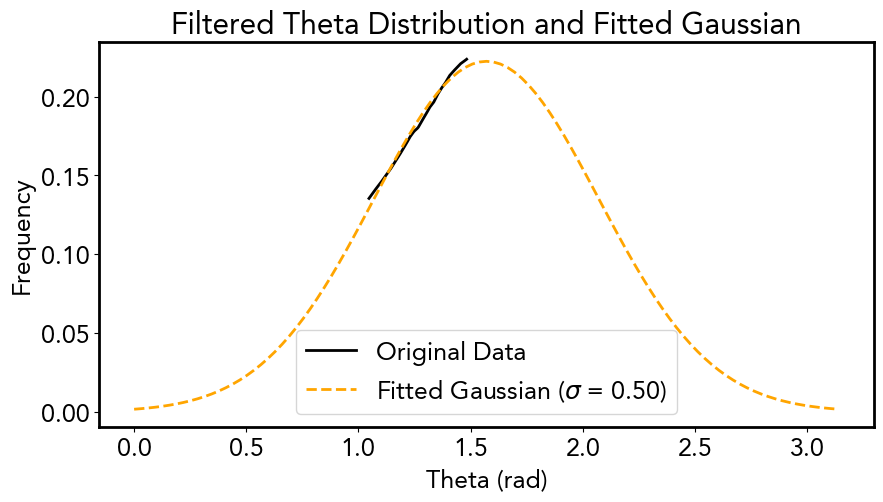

Generating theta field from fit sigma...
Generating field...
Generating fibril centers from Poisson disk sampling...
10 / 88


In [3]:
x_dim_nm = 256
y_dim_nm = x_dim_nm
z_dim_nm = 128
pitch_nm = 2

# Initialize fibril generator
fibgen = FibrilGenerator(x_dim_nm, y_dim_nm, z_dim_nm, pitch_nm)

# Define fibril generator parameters
fibril_size_params = FibrilSizeParams(
    radius_nm_avg=15, 
    radius_nm_std=3,
    min_fibril_length_nm=100, 
    max_fibril_length_nm=400
)

fibril_growth_params = FibrilGrowthParams(
    max_num_fibrils=10000, 
    fibril_distribution=FibrilDistribution.PDS,
    c2c_dist_nm=32, 
    symmetrical_growth=True, 
    periodic_bc=False
)

f=0.05
fibril_orientation_params = FibrilOrientationParams(
    fibril_orientation=FibrilOrientation.GRF_SAMPLE_ALL,
    theta_distribution_csv=r'data\theta_distributions\avg_0p1_theta_distribution.csv',
    k=1./25,
    std=1./125
    # k=1./(fibgen.x_dim*np.pi*f), 
    # std=1./(fibgen.x_dim*np.pi*f)
)

# Set fibril generator parameters
fibgen.set_model_parameters(
    fibril_size_params=fibril_size_params, 
    fibril_growth_params=fibril_growth_params,
    fibril_orientation_params=fibril_orientation_params
)

# Fill model with fibrils
fibgen.fill_model()

In [4]:
from src.Morphology.util.FieldGeneration import generate_field_with_PSD, NormalizationType

psi_ref = generate_field_with_PSD(
    k=1./25,
    std=1./125,
    dims=np.array([1024, 1024, 175]),
    max_value=2*np.pi,
    normalization_type=NormalizationType.CDF)

Generating field...


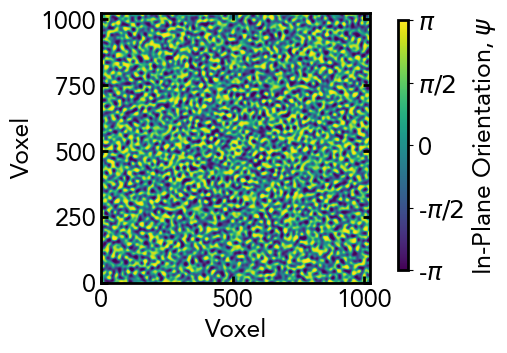

In [5]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(3.5, 3.5))

# Recreate the plot using the same data and parameters
im_cbar = ax.imshow(psi_ref[:,:,0], cmap='viridis', origin='lower', extent=[0, 1024, 0, 1024])
ax.set_xlabel('Voxel')
ax.set_ylabel('Voxel')
ax.set_title('')  # Adjust the title as necessary

cbar_ax = fig.add_axes([0.975, 0.145, 0.03, 0.715])
cbar = fig.colorbar(im_cbar, cax=cbar_ax)

# Modify colorbar tick labels to fractions of pi and label using the pi symbol
cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.set_ticklabels([r'-$\pi$', r'-$\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
cbar.ax.set_ylabel(r'In-Plane Orientation, $\psi$')

ax.xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
ax.xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
ax.yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
ax.yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

plt.show()

fig.savefig(r'C:\Users\Phong\Box\Research\Mixed Conduction Project\RSOXS Projects\Shared RSoXS Folder\Figures\orientation_field.png', dpi=300, bbox_inches='tight', transparent=True)

In [6]:
# Launch Napari viewer with a 3D display
viewer = napari.Viewer(ndisplay=3)
# You can set the theme to 'light' if preferred
# viewer.theme = 'light'

# Add the psi_ref data as an image layer to the viewer
# Customize the appearance as needed
viewer.add_image(psi_ref, name='Psi Ref', colormap='viridis', blending='additive', interpolation='linear')

# Start the Napari GUI loop
napari.run()

C:\Users\Phong\anaconda3\envs\DopantModeling-dev\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Phong\AppData\Local\Temp\ipykernel_40884\2813091292.py:8: DeprecationWarning: Argument 'interpolation' is deprecated, please use 'interpolation2d' instead. The argument 'interpolation' was deprecated in 0.4.17 and it will be removed in 0.6.0.
  viewer.add_image(psi_ref, name='Psi Ref', colormap='viridis', blending='additive', interpolation='linear')


In [7]:
p.edge_to_find = 'C_1s'
configure_energies(p)
configure_polymer_NEXAFS(p)
p.dopant = None
p.material_dict['Material4'] = 'vacuum'
data, post_processor = process_morphology(fibgen, p)
post_processor.save_parameters(data, fibgen, p, 'undoped')

Creating morphology data object.: 100%|████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.63it/s]


Setting amorphous matrix...
Adjusting amorphous matrix for density...


0.09999999999999998

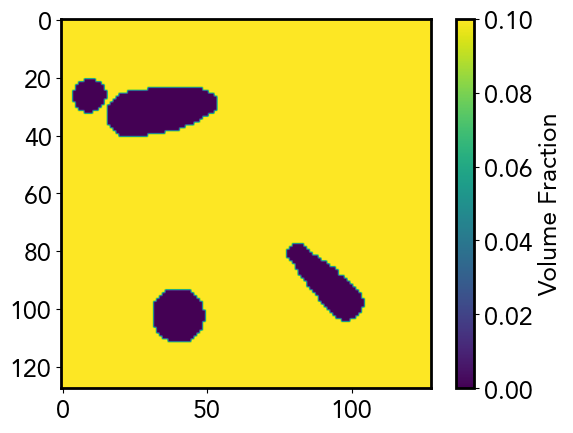

In [8]:
im = plt.imshow(data.mat_Vfrac[Materials.VACUUM_ID][10,:,:])
plt.colorbar(im, label='Volume Fraction')

np.nanmax(data.mat_Vfrac[Materials.VACUUM_ID])

1.0

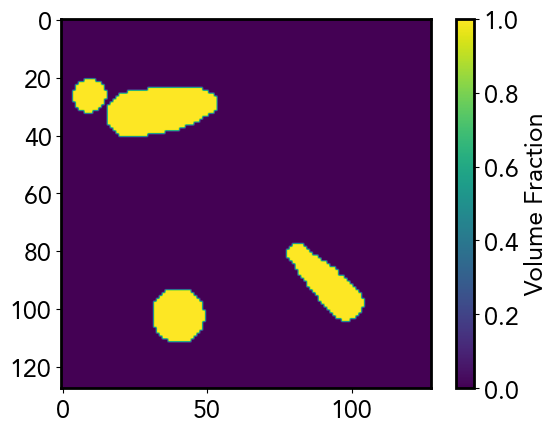

In [9]:
im = plt.imshow(data.mat_Vfrac[Materials.CRYSTAL_ID][10,:,:], vmin = 0, vmax = 1)
plt.colorbar(im, label='Volume Fraction')

np.nanmax(data.mat_Vfrac[Materials.CRYSTAL_ID])

0.9

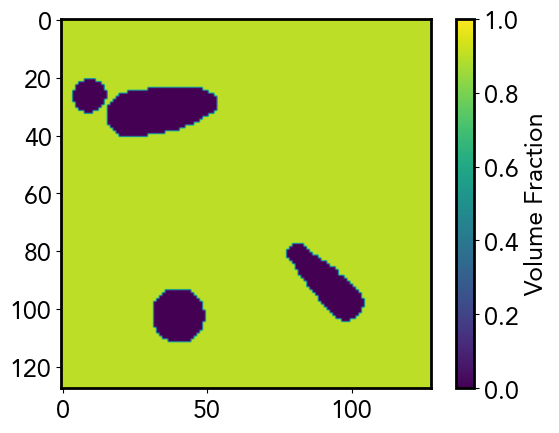

In [10]:
im = plt.imshow(data.mat_Vfrac[Materials.AMORPH_ID][10,:,:], vmin = 0, vmax = 1)
plt.colorbar(im, label='Volume Fraction')

np.nanmax(data.mat_Vfrac[Materials.AMORPH_ID])

min = 0.0
max = 0.0


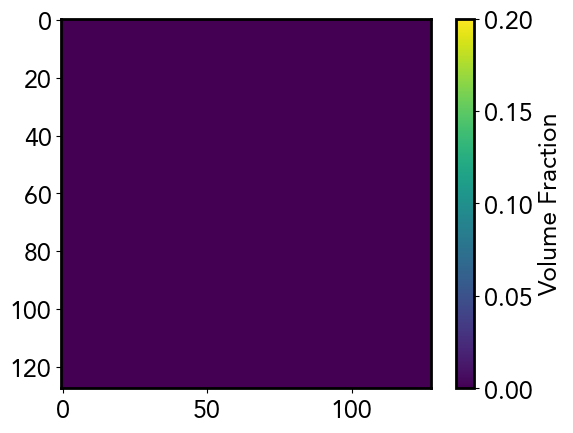

In [11]:
im = plt.imshow(data.mat_Vfrac[Materials.DOPANT_ID][10,:,:], vmin = 0, vmax = 0.2)
plt.colorbar(im, label='Volume Fraction')

print(f'min = {np.nanmin(data.mat_Vfrac[Materials.DOPANT_ID])}')
print(f'max = {np.nanmax(data.mat_Vfrac[Materials.DOPANT_ID])}')

In [12]:
# Read crystalline mole fraction from file
crystalline_mol_frac = read_crystalline_mol_frac_from_file('./parameters_undoped.txt')

# Configure dopant settings
p.dopant = 'Reduced_F4TCNQ'
p.dopant_orientation = DopantOrientation.PERPENDICULAR
configure_dopant_parameters(p, crystalline_mol_frac)

# Process doped morphology with existing data
data, post_processor = process_morphology(fibgen, p, existing_data=data, just_add_dopants=True)
post_processor.save_parameters(data, fibgen, p, 'doped')

Adding dopant...


In [13]:
data.mat_theta

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0. 

In [14]:
# Assuming 'data' is your MorphologyData object from the FibrilPostProcessor
crystal_layer = data.mat_Vfrac[Materials.CRYSTAL_ID]
amorph_layer = data.mat_Vfrac[Materials.AMORPH_ID]
dopant_layer = data.mat_Vfrac[Materials.DOPANT_ID]

# Launch Napari viewer
viewer = napari.Viewer(ndisplay=3)
# viewer.theme = 'light'

# Add layers to the viewer
viewer.add_image(crystal_layer, name='Crystalline', colormap='bop orange', gamma=2, blending='opaque', interpolation='linear', rendering='attenuated_mip')
viewer.add_image(amorph_layer, name='Amorphous', colormap='bop orange', opacity=0.2, gamma=2, blending='translucent_no_depth', interpolation='cubic', rendering='minip')
viewer.add_image(dopant_layer, name='Dopant', colormap='bop orange', opacity=0.1, gamma=2, blending='translucent_no_depth', interpolation='linear', rendering='attenuated_mip')

# Start the Napari GUI loop
napari.run()

C:\Users\Phong\AppData\Local\Temp\ipykernel_40884\617525150.py:11: DeprecationWarning: Argument 'interpolation' is deprecated, please use 'interpolation2d' instead. The argument 'interpolation' was deprecated in 0.4.17 and it will be removed in 0.6.0.
  viewer.add_image(crystal_layer, name='Crystalline', colormap='bop orange', gamma=2, blending='opaque', interpolation='linear', rendering='attenuated_mip')
C:\Users\Phong\AppData\Local\Temp\ipykernel_40884\617525150.py:12: DeprecationWarning: Argument 'interpolation' is deprecated, please use 'interpolation2d' instead. The argument 'interpolation' was deprecated in 0.4.17 and it will be removed in 0.6.0.
  viewer.add_image(amorph_layer, name='Amorphous', colormap='bop orange', opacity=0.2, gamma=2, blending='translucent_no_depth', interpolation='cubic', rendering='minip')
C:\Users\Phong\AppData\Local\Temp\ipykernel_40884\617525150.py:13: DeprecationWarning: Argument 'interpolation' is deprecated, please use 'interpolation2d' instead. The